In [18]:
import warnings
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

warnings.filterwarnings("ignore")

#import sklearn
#sklearn.show_versions()
#sklearn.__version__
set_config(display='diagram')

In [19]:
data = pd.read_csv('data/train.csv', index_col=0)

In [20]:
def GenerateFeatures(data):

    data.loc[:, 'f25xf52'] = data['f25'] * data['f52']
    data.loc[:, 'f77squared'] = data['f77'] * data['f77']
    data.loc[:, 'f12xf81'] = data['f12'] * data['f81']
    data.loc[:, 'f9xf82'] = data['f9'] * data['f82']
    data.loc[:, 'f3xf46'] = data['f3'] * data['f46']
    data.loc[:, 'f41squared'] = data['f41'] * data['f41']
    data.loc[:, 'f31xf81'] = data['f31'] * data['f81']
    data.loc[:, 'f58xf81'] = data['f58'] * data['f81']
    data.loc[:, 'ff1xf58'] = data['f41'] * data['f58']
    data.loc[:, 'f31xf74'] = data['f31'] * data['f74']
    data.loc[:, 'f3xf13'] = data['f3'] * data['f13']
    data.loc[:, 'f13xf52'] = data['f13'] * data['f52']
    data.loc[:, 'f66xf96'] = data['f66'] * data['f96']
  
    return data

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
import lightgbm as lgb

# prepare the data
y = data.pop('loss')
X = GenerateFeatures(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)


In [62]:
from flaml import AutoML

automl = AutoML()
automl.fit(X, y, metric="rmse", task="regression", time_budget=3600*1, log_file_name="automl.log", estimator_list=['xgboost', 'lgbm']) #eval_method='cv', n_splits=5,

[flaml.automl: 08-08 12:02:42] {913} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 08-08 12:02:44] {617} INFO - Using RepeatedKFold
INFO:flaml.automl:Using RepeatedKFold
[flaml.automl: 08-08 12:02:44] {934} INFO - Minimizing error metric: rmse
INFO:flaml.automl:Minimizing error metric: rmse
[flaml.automl: 08-08 12:02:44] {953} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm']
INFO:flaml.automl:List of ML learners in AutoML Run: ['xgboost', 'lgbm']
[flaml.automl: 08-08 12:02:44] {1019} INFO - iteration 0, current learner xgboost
INFO:flaml.automl:iteration 0, current learner xgboost
[flaml.automl: 08-08 12:02:45] {1174} INFO -  at 58.6s,	best xgboost's error=8.9248,	best xgboost's error=8.9248
INFO:flaml.automl: at 58.6s,	best xgboost's error=8.9248,	best xgboost's error=8.9248
[flaml.automl: 08-08 12:02:45] {1019} INFO - iteration 1, current learner lgbm
INFO:flaml.automl:iteration 1, current learner lgbm
[flaml.automl: 08-08 

In [63]:
#automl.best_estimator
automl.best_config

# best xgboos com 13 poly
# {'n_estimators': 1402,
#  'max_leaves': 4,
#  'min_child_weight': 1.62774455080513,
#  'learning_rate': 0.16483742824678932,
#  'subsample': 0.8966608043233442,
#  'colsample_bylevel': 0.37975476435962785,
#  'colsample_bytree': 0.5321790928656982,
#  'reg_alpha': 0.046742916808926054,
#  'reg_lambda': 0.0013221577956176948,
#  'FLAML_sample_size': 225000}


# best lgb com 13 poly
# [flaml.automl: 08-08 13:18:48] {1220} INFO - selected model: LGBMRegressor(colsample_bytree=0.8221354111671137,
#               learning_rate=0.035458918374876545, max_bin=64,
#               min_child_samples=27, n_estimators=458, num_leaves=66,
#               objective='regression', reg_alpha=0.0009765625,
#               reg_lambda=0.1376274886787925, subsample=0.8928092890161611)

# {'n_estimators': 599,
#  'num_leaves': 66,
#  'min_child_samples': 27,
#  'learning_rate': 0.035458918374876545,
#  'subsample': 0.8928092890161611,
#  'log_max_bin': 7,
#  'colsample_bytree': 0.8221354111671137,
#  'reg_alpha': 0.0009765625,
#  'reg_lambda': 0.1376274886787925,
#  'FLAML_sample_size': 225000}


{'n_estimators': 599,
 'num_leaves': 66,
 'min_child_samples': 27,
 'learning_rate': 0.035458918374876545,
 'subsample': 0.8928092890161611,
 'log_max_bin': 7,
 'colsample_bytree': 0.8221354111671137,
 'reg_alpha': 0.0009765625,
 'reg_lambda': 0.1376274886787925,
 'FLAML_sample_size': 225000}

In [64]:
test_data = pd.read_csv('data/test.csv', index_col=0)
test_data = GenerateFeatures(test_data)

holdout_pred = automl.predict(test_data)

test_data['loss'] = holdout_pred
submission = test_data['loss']
submission.to_csv('data/holdout_predictions.csv')
#data_to_save.reset_index()
#data_to_save.to_csv('data/holdout_predictions.csv', index=False)

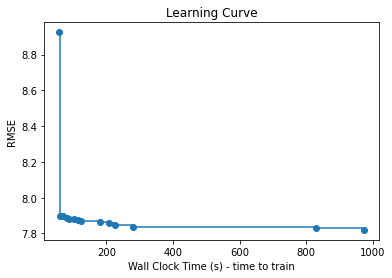

In [65]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = get_output_from_log(filename='automl.log', time_budget=3600*9)

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s) - time to train')
plt.ylabel('RMSE')
plt.scatter(time_history, np.array(valid_loss_history))
plt.step(time_history, np.array(best_valid_loss_history), where='post')
plt.show()

In [59]:
time_history

[85.65398788452148,
 87.92088484764099,
 89.20272946357727,
 91.59844756126404,
 99.06624436378479,
 106.62981247901917,
 111.25266432762146,
 117.96848845481873,
 129.93052792549133,
 218.11489844322205,
 240.5980658531189,
 317.9997236728668]